In [1]:
# Comparing my tensorflow implementation of the linear conjugate gradient method to the scipy.
# Since my implementation assumes float32 arrays, the accuracy of the results is going to be quite a bit lower.
# however, the output should be

In [2]:
import numpy as np
from scipy.sparse import linalg
import tensorflow.compat.v1 as tf
from sopt.optimizers.tensorflow.utils import MatrixFreeLinearOp, conjugate_gradient
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Creating a linear system.

In [4]:
m = np.random.randn(20, 20)

A = m @ m.T

In [5]:
# Ensuring the matrix is symmetric and positive definite. All eigvals should be positive
np.linalg.eigvals(A)

array([6.33893902e+01, 5.12762203e+01, 4.97880905e+01, 4.02159401e+01,
       3.29227876e+01, 2.61270069e+01, 2.58879488e+01, 2.24258209e+01,
       1.68808849e+01, 1.55332185e+01, 1.08107994e+01, 9.39300268e+00,
       7.31278903e+00, 6.13714863e+00, 5.57917772e+00, 3.24729125e-03,
       3.53786373e-01, 3.34788856e+00, 1.64040087e+00, 2.26245463e+00])

In [6]:
A_precond = np.linalg.inv(A * 5 + 1)

In [7]:
x_true = np.random.randn(20)
y = (A @ x_true[:,None]).reshape(-1)
x0 = np.random.randn(20)

In [8]:
# Results using scipy
def getScipyErrors(maxiter):
    x_pred = linalg.cg(A, y, maxiter=maxiter, x0=x0)[0]
    pcg_x_pred = linalg.cg(A, y, maxiter=maxiter, M=A_precond, x0=x0)[0]
    errors = x_pred - x_true
    errors_pcg = pcg_x_pred - x_true
    return np.sum(errors**2), np.sum(errors_pcg**2)

In [9]:
# Using my conjugate gradient method

In [10]:
tf.reset_default_graph()

In [11]:
A_t = tf.constant(A, dtype='float32')
A_precond_t = tf.constant(A_precond, dtype='float32')
y_t = tf.constant(y, dtype='float32')
x_true_t = tf.constant(x_true, dtype='float32')
x0_t = tf.constant(x0, dtype='float32')

In [12]:
matvec = lambda x: tf.reshape(A_t @ x[:, None], [-1])

In [13]:
linop = MatrixFreeLinearOp(operator=matvec, shape=y_t.get_shape())

In [14]:
precond_matvec = lambda x: tf.reshape(A_precond_t @ x[:, None], [-1])
precond_linop = MatrixFreeLinearOp(operator=precond_matvec, shape=y_t.get_shape())

In [15]:
maxiter = tf.placeholder(tf.int32, shape=[])
x_pred_t = conjugate_gradient(linop, y_t, tol=1e-6, max_iter=maxiter, x=x0_t)
errors_t = x_pred_t.x - x_true_t
lsq_errors_t = tf.reduce_sum(errors_t**2)

In [16]:
pcg_x_pred_t = conjugate_gradient(linop, y_t, tol=1e-6, max_iter=maxiter, preconditioner=precond_linop, x=x0_t)
pcg_errors_t = pcg_x_pred_t.x - x_true_t
pcg_lsq_errors_t = tf.reduce_sum(pcg_errors_t**2)

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
%time 
lsq_errors_scipy = []
lsq_errors_pcg_scipy = []
lsq_errors_tf = []
lsq_errors_pcg_tf = []
for i in range(1,50):
    se1, se2 = getScipyErrors(i)
    lsq_errors_scipy.append(se1)
    lsq_errors_pcg_scipy.append(se2)
    e1, e2 = sess.run([lsq_errors_t, pcg_lsq_errors_t], feed_dict={maxiter:i})
    lsq_errors_tf.append(e1)
    lsq_errors_pcg_tf.append(e2)

CPU times: user 18 µs, sys: 5 µs, total: 23 µs
Wall time: 46.3 µs


In [19]:
# The tensorflow results are less accurate after a point.

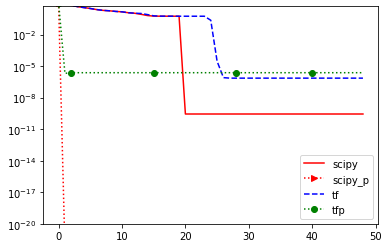

In [20]:
plt.plot(lsq_errors_scipy, color='red', label='scipy')
plt.plot(lsq_errors_pcg_scipy, color='red', ls=":", label='scipy_p', markevery=0.2, marker='>')
plt.plot(lsq_errors_tf, color='blue', ls='--', label='tf')
plt.plot(lsq_errors_pcg_tf, color='green', ls=':', label='tfp', markevery=0.2, marker='o')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim([1e-20, 5])
#plt.yscale('log')
plt.show()